In [1]:
import tensorflow.keras as keras
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions

In [2]:
def grab_image(img_path):
    img = image.load_img(img_path, color_mode="grayscale", target_size=(208, 176))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [3]:
negative_images = np.concatenate( [grab_image('AlzheimersDataset/Negative/neg(%d).jpg'%(i)) for i in range(1, 3201)])
positive_images = np.concatenate( [grab_image('AlzheimersDataset/Positive/pos(%d).jpg'%(i)) for i in range(1, 3201)])

In [4]:
# images are normalized
negative_images[0][104][60]

array([0.7019608], dtype=float32)

In [5]:
negative_labels = np.zeros(3200, dtype=int)
positive_labels = np.ones(3200, dtype=int)

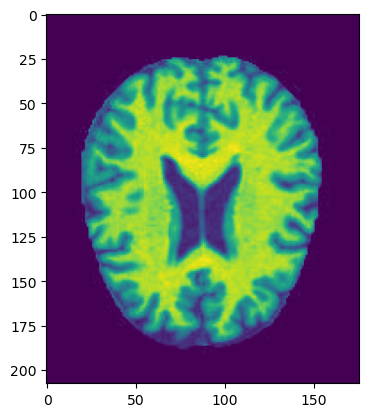

In [6]:
plt.imshow(image.array_to_img(negative_images[0,:,:,:]))
plt.show()

In [7]:
print(negative_images.shape)
print(negative_labels.shape)
print(positive_images.shape)
print(positive_labels.shape)

(3200, 208, 176, 1)
(3200,)
(3200, 208, 176, 1)
(3200,)


In [8]:
X = np.concatenate([negative_images, positive_images])
Y = np.concatenate([negative_labels, positive_labels])

In [9]:
print(X.shape)
print(Y.shape)

(6400, 208, 176, 1)
(6400,)


In [10]:
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])

In [11]:
X.shape

(6400, 36608)

In [12]:
import pandas as pd
X_df = pd.DataFrame(X)
Y_df = pd.DataFrame(Y)

In [13]:
from sklearn.decomposition import PCA
# Set number of principal components for model
n_pcs = 1000
model = PCA(n_components=n_pcs)
# Fit the model - return projected data
demo_pca = model.fit_transform(X_df)
#Create a DataFrame of the projected data
demo_pca = pd.DataFrame(demo_pca)
demo_pca.head()


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,38.252800,-12.783160,-8.045193,-5.010735,-1.399610,-13.774753,-2.727791,-6.007291,0.589698,-0.925039,...,-0.259722,-0.135965,-0.104758,0.108127,0.011780,0.513016,-0.890883,0.272077,0.221176,-0.175706
1,39.827736,-8.731515,-5.045528,-10.793721,-1.172167,-12.677871,0.476866,-8.339971,2.934720,1.972055,...,-0.110139,-0.294803,-0.074706,0.292582,-0.483643,0.044868,-0.212505,0.217979,0.435326,-0.361253
2,32.101662,13.406836,10.822085,-7.663159,-0.255020,-1.698021,-5.612581,-4.014851,-3.413306,3.799222,...,0.040153,-0.155548,0.138761,-0.603324,-0.005595,0.198585,0.222043,-0.049689,0.425138,0.303789
3,32.340240,-12.503634,-11.771415,-6.380079,2.330409,-15.401357,2.721613,-0.001748,-3.115627,1.464917,...,-0.281867,0.764739,-0.246056,-0.158382,0.747626,-0.335539,0.229613,-0.391723,-0.067952,0.208696
4,37.411884,-18.802122,-14.203749,-3.392531,-4.004668,-11.806997,2.928631,-5.533795,4.511383,2.286417,...,0.336724,-0.121126,0.373865,-0.107504,0.153101,0.315791,-0.049923,0.241486,0.270612,-0.429038


In [14]:
names = []
for x in range(n_pcs):
    names.append('PC%d'%(x+1))

In [15]:
demo_pca.columns = names
demo_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC991,PC992,PC993,PC994,PC995,PC996,PC997,PC998,PC999,PC1000
0,38.252800,-12.783160,-8.045193,-5.010735,-1.399610,-13.774753,-2.727791,-6.007291,0.589698,-0.925039,...,-0.259722,-0.135965,-0.104758,0.108127,0.011780,0.513016,-0.890883,0.272077,0.221176,-0.175706
1,39.827736,-8.731515,-5.045528,-10.793721,-1.172167,-12.677871,0.476866,-8.339971,2.934720,1.972055,...,-0.110139,-0.294803,-0.074706,0.292582,-0.483643,0.044868,-0.212505,0.217979,0.435326,-0.361253
2,32.101662,13.406836,10.822085,-7.663159,-0.255020,-1.698021,-5.612581,-4.014851,-3.413306,3.799222,...,0.040153,-0.155548,0.138761,-0.603324,-0.005595,0.198585,0.222043,-0.049689,0.425138,0.303789
3,32.340240,-12.503634,-11.771415,-6.380079,2.330409,-15.401357,2.721613,-0.001748,-3.115627,1.464917,...,-0.281867,0.764739,-0.246056,-0.158382,0.747626,-0.335539,0.229613,-0.391723,-0.067952,0.208696
4,37.411884,-18.802122,-14.203749,-3.392531,-4.004668,-11.806997,2.928631,-5.533795,4.511383,2.286417,...,0.336724,-0.121126,0.373865,-0.107504,0.153101,0.315791,-0.049923,0.241486,0.270612,-0.429038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6395,33.773766,-11.727565,-8.286859,-6.862197,-0.171424,-15.567822,-0.663160,-1.979142,-1.168524,-4.371510,...,0.016063,0.108221,0.075478,0.043021,-0.462235,-0.087721,-0.380243,-0.169628,-0.013848,-0.059165
6396,43.879562,-0.707606,3.495208,-3.713598,2.271031,-7.418604,-3.877172,-10.506691,3.013709,-2.524945,...,-0.110437,-0.323519,0.247330,0.165449,-0.122498,-0.288361,-0.398267,-0.483278,-0.009554,0.034948
6397,34.445053,21.247007,2.338242,-9.818328,-7.375978,7.034761,-6.395083,-0.304639,2.905234,-3.284770,...,0.490253,0.323384,0.266711,-0.122219,0.431443,0.566390,0.050797,-0.021036,-0.189177,-0.206120
6398,40.546940,1.290989,-4.215466,-13.022493,-5.034539,-4.375691,-2.346033,-9.238958,-2.311399,-2.398288,...,-0.202789,0.178281,0.720861,0.303631,0.265924,-0.021407,0.260117,-0.235682,0.318398,0.472140


In [18]:
explained_ratio = model.explained_variance_ratio_
explained_ratio = pd.DataFrame(explained_ratio).reset_index()
explained_ratio = explained_ratio.rename(columns = {0: 'explained_ratio', 'index': 'PC'})
explained_ratio['explained_ratio_sum']= np.cumsum(explained_ratio.explained_ratio)
explained_ratio

,PC,explained_ratio,explained_ratio_sum
0,0,0.221449,0.221449
1,1,0.105193,0.326642
2,2,0.078420,0.405062
3,3,0.032906,0.437968
4,4,0.022070,0.460037
...,...,...,...
995,995,0.000043,0.970140
996,996,0.000043,0.970182
997,997,0.000042,0.970224
998,998,0.000042,0.970266


In [21]:
df_pca = pd.concat([demo_pca, Y_df], axis=1)

In [23]:
df_pca = df_pca.rename(columns = {0:'label'})

In [24]:
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC992,PC993,PC994,PC995,PC996,PC997,PC998,PC999,PC1000,label
0,38.252800,-12.783160,-8.045193,-5.010735,-1.399610,-13.774753,-2.727791,-6.007291,0.589698,-0.925039,...,-0.135965,-0.104758,0.108127,0.011780,0.513016,-0.890883,0.272077,0.221176,-0.175706,0
1,39.827736,-8.731515,-5.045528,-10.793721,-1.172167,-12.677871,0.476866,-8.339971,2.934720,1.972055,...,-0.294803,-0.074706,0.292582,-0.483643,0.044868,-0.212505,0.217979,0.435326,-0.361253,0
2,32.101662,13.406836,10.822085,-7.663159,-0.255020,-1.698021,-5.612581,-4.014851,-3.413306,3.799222,...,-0.155548,0.138761,-0.603324,-0.005595,0.198585,0.222043,-0.049689,0.425138,0.303789,0
3,32.340240,-12.503634,-11.771415,-6.380079,2.330409,-15.401357,2.721613,-0.001748,-3.115627,1.464917,...,0.764739,-0.246056,-0.158382,0.747626,-0.335539,0.229613,-0.391723,-0.067952,0.208696,0
4,37.411884,-18.802122,-14.203749,-3.392531,-4.004668,-11.806997,2.928631,-5.533795,4.511383,2.286417,...,-0.121126,0.373865,-0.107504,0.153101,0.315791,-0.049923,0.241486,0.270612,-0.429038,0


In [27]:
from pathlib import Path  
filepath = Path('out.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_pca.to_csv(filepath, index=False) 